# Import Library

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
import os

# Hyperparameter Setting

In [195]:
config = {
    "learning_rate": 0.009,
    "epoch": 100,
    "batch_size": 64,
    "hidden_size": 108,
    "num_layers": 3,
    "output_size": 3,
    "dropout": 0.48
}

CFG = SimpleNamespace(**config)

item_list = ['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파']

하이퍼 파라미터 수정

# Define Function for Feature Engineering

In [196]:
import re
from datetime import datetime

def parse_custom_date(date_str):
    # 접두사 'T-' 제거
    if date_str.startswith('T-'):
        date_str = date_str.lstrip('T-')
    
    # 정규식으로 날짜를 파싱
    match = re.match(r"(\d{4})(\d{2})(상순|중순|하순)", date_str)
    if match:
        year, month, part = match.groups()
        # 상순, 중순, 하순을 각각 1일, 11일, 21일로 매핑
        day = {"상순": "01", "중순": "11", "하순": "21"}[part]
        # 날짜 생성
        return datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")
    else:
        return None


날짜 변환 함수

#### 컬럼명 수정

In [197]:
def process_data(raw_file, 산지공판장_file, 전국도매_file, 품목명, scaler=None):
    raw_data = pd.read_csv(raw_file)
    산지공판장 = pd.read_csv(산지공판장_file)
    전국도매 = pd.read_csv(전국도매_file)

    # 타겟 및 메타데이터 필터 조건 정의
    conditions = {
    '감자': {
        'target': lambda df: (df['품종명'] == '감자 수미') & (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['감자'], '품종명': ['수미'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['감자'], '품종명': ['수미']}
    },
    '건고추': {
        'target': lambda df: (df['품종명'] == '화건') & (df['거래단위'] == '30 kg') & (df['등급'] == '상품'),
        '공판장': None, 
        '도매': None  
    },
    '깐마늘(국산)': {
        'target': lambda df: (df['거래단위'] == '20 kg') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['마늘'], '품종명': ['깐마늘'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['마늘'], '품종명': ['깐마늘']}
    },
    '대파': {
        'target': lambda df: (df['품종명'] == '대파(일반)') & (df['거래단위'] == '1키로단') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['대파'], '품종명': ['대파(일반)'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['대파'], '품종명': ['대파(일반)']}
    },
    '무': {
        'target': lambda df: (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['무'], '품종명': ['기타무'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['무'], '품종명': ['무']}
    },
    '배추': {
        'target': lambda df: (df['거래단위'] == '10키로망대') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배추'], '품종명': ['쌈배추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배추'], '품종명': ['배추']}
    },
    '사과': {
        'target': lambda df: (df['품종명'].isin(['홍로', '후지'])) & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['사과'], '품종명': ['후지'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['사과'], '품종명': ['후지']}
    },
    '상추': {
        'target': lambda df: (df['품종명'] == '청') & (df['거래단위'] == '100 g') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['상추'], '품종명': ['청상추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['상추'], '품종명': ['청상추']}
    },
    '양파': {
        'target': lambda df: (df['품종명'] == '양파') & (df['거래단위'] == '1키로') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['양파'], '품종명': ['기타양파'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['양파'], '품종명': ['양파(일반)']}
    },
    '배': {
        'target': lambda df: (df['품종명'] == '신고') & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배'], '품종명': ['신고'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배'], '품종명': ['신고']}
    }
    }

    # 타겟 데이터 필터링
    raw_품목 = raw_data[raw_data['품목명'] == 품목명]
    target_mask = conditions[품목명]['target'](raw_품목)
    filtered_data = raw_품목[target_mask]

    # 다른 품종에 대한 파생변수 생성
    other_data = raw_품목[~target_mask]
    unique_combinations = other_data[['품종명', '거래단위', '등급']].drop_duplicates()
    for _, row in unique_combinations.iterrows():
        품종명, 거래단위, 등급 = row['품종명'], row['거래단위'], row['등급']
        mask = (other_data['품종명'] == 품종명) & (other_data['거래단위'] == 거래단위) & (other_data['등급'] == 등급)
        temp_df = other_data[mask]
        for col in ['평년 평균가격(원)', '평균가격(원)']:
            new_col_name = f'{품종명}_{거래단위}_{등급}_{col}'
            filtered_data = filtered_data.merge(temp_df[['시점', col]], on='시점', how='left', suffixes=('', f'_{new_col_name}'))
            filtered_data.rename(columns={f'{col}_{new_col_name}': new_col_name}, inplace=True)


    # 공판장 데이터 처리
    if conditions[품목명]['공판장']:
        filtered_공판장 = 산지공판장
        for key, value in conditions[품목명]['공판장'].items():
            filtered_공판장 = filtered_공판장[filtered_공판장[key].isin(value)]
        
        filtered_공판장 = filtered_공판장.add_prefix('공판장_').rename(columns={'공판장_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_공판장, on='시점', how='left')

    # 도매 데이터 처리
    if conditions[품목명]['도매']:
        filtered_도매 = 전국도매
        for key, value in conditions[품목명]['도매'].items():
            filtered_도매 = filtered_도매[filtered_도매[key].isin(value)]
        
        filtered_도매 = filtered_도매.add_prefix('도매_').rename(columns={'도매_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_도매, on='시점', how='left')
    
    ### 날짜변환
    filtered_data['시점'] = filtered_data['시점'].apply(parse_custom_date)

    # 수치형 컬럼 처리
    numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
    filtered_data = filtered_data[['시점'] + list(numeric_columns)]
    filtered_data[numeric_columns] = filtered_data[numeric_columns].fillna(0)

    ### 결측치 처리: 선형 보간법
    filtered_data[numeric_columns] = filtered_data[numeric_columns].interpolate(method='linear', limit_direction='both')

    ### 이상치 처리: IQR 방법 ###
#    for col in numeric_columns:
#        Q1 = filtered_data[col].quantile(0.25)
#        Q3 = filtered_data[col].quantile(0.75)
#        IQR = Q3 - Q1
#        lower_bound = Q1 - 1.5 * IQR
#        upper_bound = Q3 + 1.5 * IQR
#        filtered_data = filtered_data[(filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)]
    #######

#####mentori님의 이상치 처리 부분 참고 ######
    for col in numeric_columns:
        for i in range(1, len(filtered_data)):
            if filtered_data.loc[i, col] == 0:  # 0인 값을 이상치로 간주
                filtered_data.loc[i, col] = filtered_data.loc[i - 1, col]  # 이전 값으로 대체

    # 평균가격 값이 0인 것이 일정 수준 이하라면 그 칼럼을 제거한다.
    drop_columns = []
    for col in filtered_data.columns:
        zero_cols = len(filtered_data[filtered_data[col]==0])
        if zero_cols/len(filtered_data) > 0.5:
            drop_columns.append(col)
###################################################

    # 정규화 적용
    if scaler is None:
        scaler = MinMaxScaler()
        filtered_data[numeric_columns] = scaler.fit_transform(filtered_data[numeric_columns])
    else:
        filtered_data[numeric_columns] = scaler.transform(filtered_data[numeric_columns])

    return filtered_data, scaler


기존 베이스라인 코드에다가 아래 사항들을 추가함.   
    
(1) 이상치 처리: IQR을 사용해 이상치를 식별하고 제거. ((각 수치형 컬럼에 대해 1.5 * IQR 범위를 벗어난 값을 제거.  
  => 가끔가다 0인 경우에서 에러가 남. 이상치처리부분을 극단적인 이상치만 평균값으로 대체하는 방식으로 전환하였음.  
  =>이상치가 0인 경우는 이전값으로 대체했더니 loss가 줄어들었음
  
(2) 시간 변수 추가: 시점에서 연도, 월, 분기, 계절 정보를 파생 변수로 생성.   
 
(3) 결측치 처리: 선형 보간법을 사용해 연속적인 시간 데이터를 고려한 결측치 보완.

# Define Custom Dataset Class

In [157]:
class AgriculturePriceDataset(Dataset):
    def __init__(self, dataframe, window_size=9, prediction_length=3, is_test=False):
        self.data = dataframe
        self.window_size = window_size
        self.prediction_length = prediction_length
        self.is_test = is_test
        
        self.price_column = '평균가격(원)' 
        self.numeric_columns = self.data.select_dtypes(include=[np.number]).columns.tolist()
        
        self.sequences = []
        if not self.is_test:
            for i in range(len(self.data) - self.window_size - self.prediction_length + 1):
                x = self.data[self.numeric_columns].iloc[i:i+self.window_size].values
                y = self.data[self.price_column].iloc[i+self.window_size:i+self.window_size+self.prediction_length].values
                self.sequences.append((x, y))
        else:
            self.sequences = [self.data[self.numeric_columns].values]
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        if not self.is_test:
            x, y = self.sequences[idx]
            return torch.FloatTensor(x), torch.FloatTensor(y)
        else:
            return torch.FloatTensor(self.sequences[idx])


# Define Model and Training Functions

### LSTM

In [202]:
class PricePredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout = 0.48):
        super(PricePredictionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)  # Dropout 추가
        self.fc1 = nn.Linear(hidden_size * 2, 128)  # 첫 번째 FC 레이어 (hidden_size * 2 -> 128)
        self.fc2 = nn.Linear(128, output_size)  # 두 번째 FC 레이어 (128 -> output_size)
        self.relu = nn.ReLU()  # ReLU 활성화 함수
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # 마지막 타임스텝의 출력값을 사용
        out = out[:, -1, :]  
        
        # Dropout을 추가하고 ReLU 활성화 함수 적용
        out = self.dropout(out)
        out = self.fc1(out)  # 첫 번째 FC 레이어
        out = self.relu(out)  # ReLU 활성화 함수
        out = self.fc2(out)  # 두 번째 FC 레이어
        return out

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)  

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    return total_loss / len(test_loader)

Index(['시점', '평년 평균가격(원)', '평균가격(원)', '다발무_10키로_중_평년 평균가격(원)',
       '다발무_10키로_중_평균가격(원)', '무_18키로상자(비닐포)_중_평년 평균가격(원)',
       '무_18키로상자(비닐포)_중_평균가격(원)', '무_20키로상자_중_평년 평균가격(원)',
       '무_20키로상자_중_평균가격(원)', '다발무_5000키로_중_평년 평균가격(원)',
       ...
       '도매_저가(20%) 평균가', '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)',
       '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object', length=101)


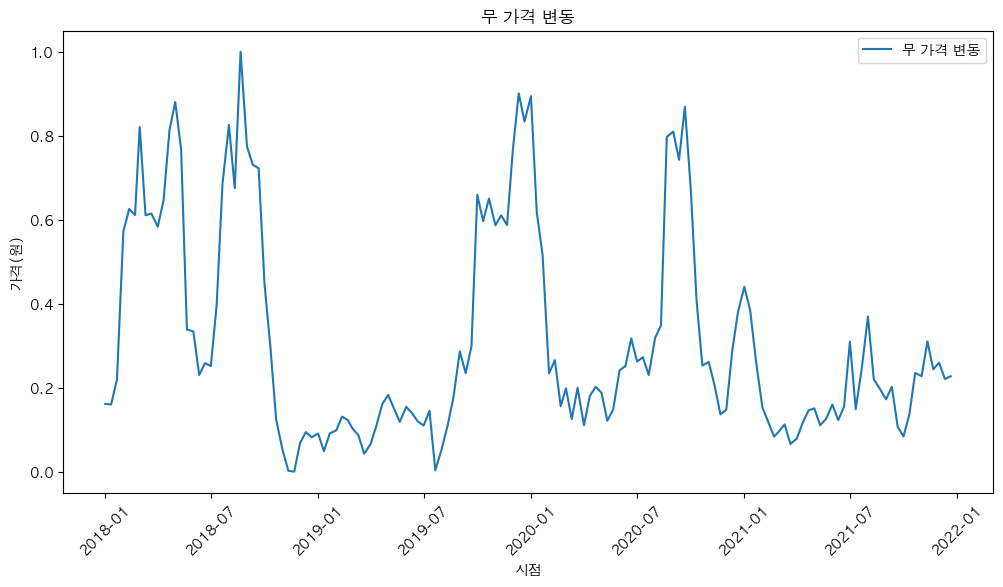

                        시점  평년 평균가격(원)     평균가격(원)  다발무_10키로_중_평년 평균가격(원)  \
count                  144       144.0  144.000000                  144.0   
mean   2019-12-26 11:00:00         0.0    0.314293                    0.0   
min    2018-01-01 00:00:00         0.0    0.000000                    0.0   
25%    2018-12-29 06:00:00         0.0    0.124911                    0.0   
50%    2019-12-26 12:00:00         0.0    0.227274                    0.0   
75%    2020-12-23 18:00:00         0.0    0.442096                    0.0   
max    2021-12-21 00:00:00         0.0    1.000000                    0.0   
std                    NaN         0.0    0.250560                    0.0   

       다발무_10키로_중_평균가격(원)  무_18키로상자(비닐포)_중_평년 평균가격(원)  \
count          144.000000                  144.000000   
mean             0.184229                    0.952918   
min              0.000000                    0.000000   
25%              0.000000                    1.000000   
50%              0.00

In [203]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'  # Windows에서 "맑은 고딕" 폰트 사용
mpl.rcParams['axes.unicode_minus'] = False

품목명 = "무"  

# 데이터를 전처리
train_data, scaler = process_data(
    "./train/train.csv", 
    "./train/meta/TRAIN_산지공판장_2018-2021.csv", 
    "./train/meta/TRAIN_전국도매_2018-2021.csv", 
    품목명
)

# 열 이름 확인
print(train_data.columns)

# 특성 파악을 위해 '가격' 관련 열을 시각화 (예시로 '가격' 열을 사용)
# 이 부분은 데이터에 맞게 수정 필요
plt.figure(figsize=(12, 6))
plt.plot(train_data['시점'], train_data['평균가격(원)'], label=f"{품목명} 가격 변동")
plt.title(f"{품목명} 가격 변동")
plt.xlabel('시점')
plt.ylabel('가격(원)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 기본적인 통계 확인
print(train_data.describe())


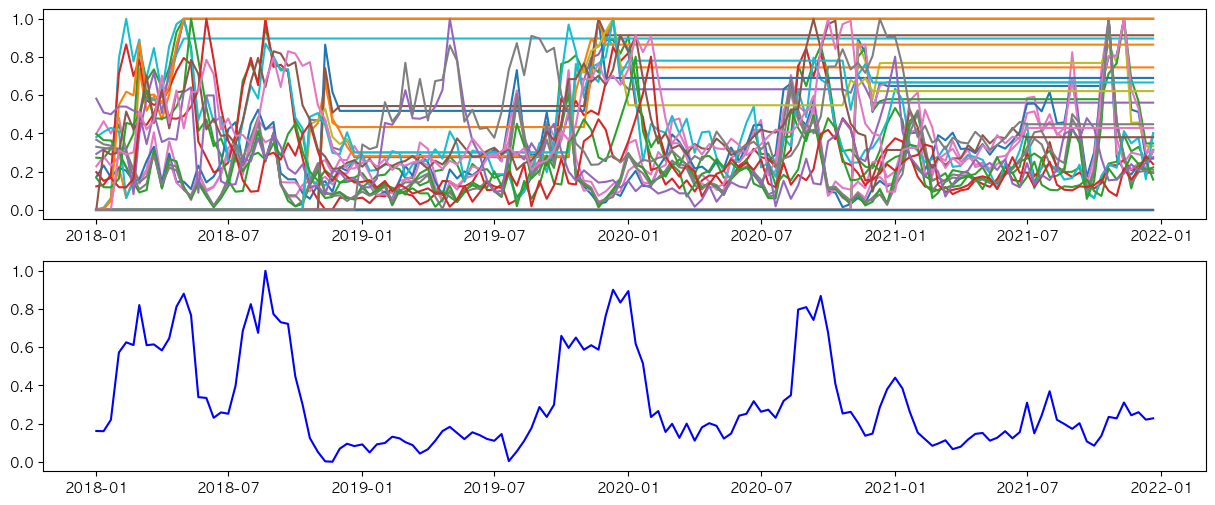

In [160]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6))

for col in train_data.columns:
    if "평균가격" in col and "평년" not in col and col != "평균가격(원)":

        # 극단적인 이상치만 평균값으로 대체
        for i in range(1, len(train_data)):
            if train_data.loc[i, col] == 0:
                train_data.loc[i, col] = train_data.loc[i - 1, col]

        axs[0].plot(train_data["시점"], train_data[col], label=col)
axs[1].plot(train_data["시점"], train_data['평균가격(원)'], color="blue")

# Train Models and Generate Predictions

In [161]:
from tqdm import tqdm  # Jupyter Notebook 호환 모드
pbar_outer = tqdm(item_list, desc="품목 처리 중", position=0)

품목 처리 중:   0%|          | 0/10 [00:00<?, ?it/s]

In [176]:
class NMAELoss(nn.Module):
    def __init__(self):
        super(NMAELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mae = torch.abs(y_pred - y_true).mean()
        # y_true의 평균을 기준으로 정규화
        nmae = mae / torch.mean(torch.abs(y_true))
        return nmae

In [204]:
품목별_predictions = {}
품목별_scalers = {}

pbar_outer = tqdm(item_list, desc="품목 처리 중", position=0)
for 품목명 in pbar_outer:
    pbar_outer.set_description(f"품목별 전처리 및 모델 학습 -> {품목명}")
    
    # 데이터 로드 및 전처리
    train_data, scaler = process_data("./train/train.csv", 
                                      "./train/meta/TRAIN_산지공판장_2018-2021.csv", 
                                      "./train/meta/TRAIN_전국도매_2018-2021.csv", 
                                      품목명)
    품목별_scalers[품목명] = scaler
    dataset = AgriculturePriceDataset(train_data)

###
    drop_col = []
    for col in train_data.columns:
        zeros = len(train_data[train_data[col]==0])
        if zeros/len(train_data) > 0.75:
            drop_col.append(col)
    train_data = train_data.drop(columns=drop_col)
###

    # 데이터를 train과 validation으로 분할
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    
    train_loader = DataLoader(train_data, CFG.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, CFG.batch_size, shuffle=False)

    input_size = len(dataset.numeric_columns)
    
    model = PricePredictionLSTM(input_size, CFG.hidden_size, CFG.num_layers, CFG.output_size)
    criterion = NMAELoss()
    optimizer = torch.optim.Adam(model.parameters(), CFG.learning_rate)
    
    best_val_loss = float('inf')
    os.makedirs('models', exist_ok=True)

    for epoch in range(CFG.epoch):
        train_loss = train_model(model, train_loader, criterion, optimizer, CFG.epoch)
        val_loss = evaluate_model(model, val_loader, criterion)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'models/best_model_{품목명}.pth')
        
        print(f'Epoch {epoch+1}/{CFG.epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    print(f'Best Validation Loss for {품목명}: {best_val_loss:.4f}')
    
    품목_predictions = []

    ### 추론 
    pbar_inner = tqdm(range(25), desc="테스트 파일 추론 중", position=1, leave=False)
    for i in pbar_inner:
        test_file = f"./test/TEST_{i:02d}.csv"
        산지공판장_file = f"./test/meta/TEST_산지공판장_{i:02d}.csv"
        전국도매_file = f"./test/meta/TEST_전국도매_{i:02d}.csv"
        
        test_data, _ = process_data(test_file, 산지공판장_file, 전국도매_file, 품목명, scaler=품목별_scalers[품목명])
        test_dataset = AgriculturePriceDataset(test_data, is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                output = model(batch)
                predictions.append(output.numpy())
        
        predictions_array = np.concatenate(predictions)

        # 예측값을 원래 스케일로 복원
        price_column_index = test_data.columns.get_loc(test_dataset.price_column)
        predictions_reshaped = predictions_array.reshape(-1, 1)
        
        # 가격 열에 대해서만 inverse_transform 적용
        price_scaler = MinMaxScaler()
        price_scaler.min_ = 품목별_scalers[품목명].min_[price_column_index]
        price_scaler.scale_ = 품목별_scalers[품목명].scale_[price_column_index]
        predictions_original_scale = price_scaler.inverse_transform(predictions_reshaped)
        #print(predictions_original_scale)
        
        if np.isnan(predictions_original_scale).any():
            pbar_inner.set_postfix({"상태": "NaN"})
        else:
            pbar_inner.set_postfix({"상태": "정상"})
            품목_predictions.extend(predictions_original_scale.flatten())

            
    품목별_predictions[품목명] = 품목_predictions
    pbar_outer.update(1)



품목별 전처리 및 모델 학습 -> 건고추:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.8364, Val Loss: 6.6499
Epoch 2/100, Train Loss: 3.1160, Val Loss: 0.7175
Epoch 3/100, Train Loss: 0.8295, Val Loss: 0.8701
Epoch 4/100, Train Loss: 0.8519, Val Loss: 0.6691
Epoch 5/100, Train Loss: 0.6213, Val Loss: 0.5920
Epoch 6/100, Train Loss: 0.4950, Val Loss: 0.3860
Epoch 7/100, Train Loss: 0.6000, Val Loss: 0.1950
Epoch 8/100, Train Loss: 0.4229, Val Loss: 0.3712
Epoch 9/100, Train Loss: 0.3936, Val Loss: 0.4606
Epoch 10/100, Train Loss: 0.4359, Val Loss: 0.2550
Epoch 11/100, Train Loss: 0.3740, Val Loss: 0.2850
Epoch 12/100, Train Loss: 0.3359, Val Loss: 0.3260
Epoch 13/100, Train Loss: 0.3405, Val Loss: 0.2081
Epoch 14/100, Train Loss: 0.3142, Val Loss: 0.2125
Epoch 15/100, Train Loss: 0.2761, Val Loss: 0.2021
Epoch 16/100, Train Loss: 0.2471, Val Loss: 0.1457
Epoch 17/100, Train Loss: 0.2130, Val Loss: 0.1452
Epoch 18/100, Train Loss: 0.2076, Val Loss: 0.1328
Epoch 19/100, Train Loss: 0.2031, Val Loss: 0.1289
Epoch 20/100, Train Loss: 0.2088, Val Lo


품목별 전처리 및 모델 학습 -> 사과:  20%|██        | 2/10 [00:08<01:05,  8.20s/it]          

Epoch 1/100, Train Loss: 0.7433, Val Loss: 0.4440
Epoch 2/100, Train Loss: 0.6550, Val Loss: 0.5298
Epoch 3/100, Train Loss: 0.7619, Val Loss: 0.6104
Epoch 4/100, Train Loss: 0.5883, Val Loss: 0.5858
Epoch 5/100, Train Loss: 0.4917, Val Loss: 0.4083
Epoch 6/100, Train Loss: 0.4606, Val Loss: 0.3130
Epoch 7/100, Train Loss: 0.4556, Val Loss: 0.5062
Epoch 8/100, Train Loss: 0.3805, Val Loss: 0.5176
Epoch 9/100, Train Loss: 0.4295, Val Loss: 0.3197
Epoch 10/100, Train Loss: 0.3284, Val Loss: 0.3719
Epoch 11/100, Train Loss: 0.3287, Val Loss: 0.3058
Epoch 12/100, Train Loss: 0.2740, Val Loss: 0.3250
Epoch 13/100, Train Loss: 0.2965, Val Loss: 0.2877
Epoch 14/100, Train Loss: 0.2613, Val Loss: 0.2885
Epoch 15/100, Train Loss: 0.2425, Val Loss: 0.3087
Epoch 16/100, Train Loss: 0.2571, Val Loss: 0.2712
Epoch 17/100, Train Loss: 0.2555, Val Loss: 0.2388
Epoch 18/100, Train Loss: 0.2085, Val Loss: 0.2342
Epoch 19/100, Train Loss: 0.2192, Val Loss: 0.2271
Epoch 20/100, Train Loss: 0.2362, Val Lo


품목별 전처리 및 모델 학습 -> 감자:  40%|████      | 4/10 [00:18<00:34,  5.77s/it]          

Epoch 1/100, Train Loss: 1.3165, Val Loss: 0.7951
Epoch 2/100, Train Loss: 0.7520, Val Loss: 1.2773
Epoch 3/100, Train Loss: 1.0527, Val Loss: 0.5922
Epoch 4/100, Train Loss: 0.6255, Val Loss: 0.5574
Epoch 5/100, Train Loss: 0.5762, Val Loss: 0.6133
Epoch 6/100, Train Loss: 0.5910, Val Loss: 0.5166
Epoch 7/100, Train Loss: 0.4785, Val Loss: 0.4164
Epoch 8/100, Train Loss: 0.4631, Val Loss: 0.3510
Epoch 9/100, Train Loss: 0.3618, Val Loss: 0.4189
Epoch 10/100, Train Loss: 0.4147, Val Loss: 0.4543
Epoch 11/100, Train Loss: 0.4052, Val Loss: 0.3489
Epoch 12/100, Train Loss: 0.4030, Val Loss: 0.3369
Epoch 13/100, Train Loss: 0.3649, Val Loss: 0.4431
Epoch 14/100, Train Loss: 0.3018, Val Loss: 0.3943
Epoch 15/100, Train Loss: 0.2825, Val Loss: 0.5579
Epoch 16/100, Train Loss: 0.2775, Val Loss: 0.3584
Epoch 17/100, Train Loss: 0.2265, Val Loss: 0.3255
Epoch 18/100, Train Loss: 0.2355, Val Loss: 0.3702
Epoch 19/100, Train Loss: 0.2507, Val Loss: 0.3247
Epoch 20/100, Train Loss: 0.2399, Val Lo


품목별 전처리 및 모델 학습 -> 배:  50%|█████     | 5/10 [00:33<00:34,  6.88s/it]           

Epoch 1/100, Train Loss: 0.7601, Val Loss: 1.0134
Epoch 2/100, Train Loss: 0.9802, Val Loss: 0.5557
Epoch 3/100, Train Loss: 0.5386, Val Loss: 0.8999
Epoch 4/100, Train Loss: 0.8378, Val Loss: 0.5415
Epoch 5/100, Train Loss: 0.5360, Val Loss: 0.4514
Epoch 6/100, Train Loss: 0.4641, Val Loss: 0.4735
Epoch 7/100, Train Loss: 0.4210, Val Loss: 0.4245
Epoch 8/100, Train Loss: 0.3430, Val Loss: 0.4409
Epoch 9/100, Train Loss: 0.3182, Val Loss: 0.2668
Epoch 10/100, Train Loss: 0.2705, Val Loss: 0.2399
Epoch 11/100, Train Loss: 0.2706, Val Loss: 0.1913
Epoch 12/100, Train Loss: 0.2579, Val Loss: 0.2622
Epoch 13/100, Train Loss: 0.2463, Val Loss: 0.2665
Epoch 14/100, Train Loss: 0.2378, Val Loss: 0.2645
Epoch 15/100, Train Loss: 0.2549, Val Loss: 0.2180
Epoch 16/100, Train Loss: 0.2313, Val Loss: 0.1976
Epoch 17/100, Train Loss: 0.2419, Val Loss: 0.2408
Epoch 18/100, Train Loss: 0.2305, Val Loss: 0.2134
Epoch 19/100, Train Loss: 0.2058, Val Loss: 0.2230
Epoch 20/100, Train Loss: 0.1860, Val Lo


품목별 전처리 및 모델 학습 -> 깐마늘(국산):  70%|███████   | 7/10 [00:43<00:22,  7.48s/it]     

Epoch 1/100, Train Loss: 0.7509, Val Loss: 6.0960
Epoch 2/100, Train Loss: 3.5628, Val Loss: 0.4917
Epoch 3/100, Train Loss: 0.6445, Val Loss: 0.8081
Epoch 4/100, Train Loss: 0.8176, Val Loss: 0.7949
Epoch 5/100, Train Loss: 0.7846, Val Loss: 0.6253
Epoch 6/100, Train Loss: 0.5925, Val Loss: 0.7737
Epoch 7/100, Train Loss: 0.6173, Val Loss: 0.5504
Epoch 8/100, Train Loss: 0.5620, Val Loss: 0.4815
Epoch 9/100, Train Loss: 0.5232, Val Loss: 0.4927
Epoch 10/100, Train Loss: 0.5169, Val Loss: 0.5936
Epoch 11/100, Train Loss: 0.5258, Val Loss: 0.5860
Epoch 12/100, Train Loss: 0.4899, Val Loss: 0.4747
Epoch 13/100, Train Loss: 0.4356, Val Loss: 0.3980
Epoch 14/100, Train Loss: 0.3632, Val Loss: 0.2964
Epoch 15/100, Train Loss: 0.2823, Val Loss: 0.3604
Epoch 16/100, Train Loss: 0.2700, Val Loss: 0.2512
Epoch 17/100, Train Loss: 0.1848, Val Loss: 0.1870
Epoch 18/100, Train Loss: 0.1925, Val Loss: 0.1698
Epoch 19/100, Train Loss: 0.2046, Val Loss: 0.1766
Epoch 20/100, Train Loss: 0.2216, Val Lo


품목별 전처리 및 모델 학습 -> 무:  80%|████████  | 8/10 [00:52<00:12,  6.32s/it]           

Epoch 1/100, Train Loss: 0.8052, Val Loss: 0.5850
Epoch 2/100, Train Loss: 0.7133, Val Loss: 1.0174
Epoch 3/100, Train Loss: 0.8555, Val Loss: 0.5560
Epoch 4/100, Train Loss: 0.5872, Val Loss: 0.5592
Epoch 5/100, Train Loss: 0.6042, Val Loss: 0.5615
Epoch 6/100, Train Loss: 0.6382, Val Loss: 0.5376
Epoch 7/100, Train Loss: 0.5790, Val Loss: 0.5339
Epoch 8/100, Train Loss: 0.5710, Val Loss: 0.4878
Epoch 9/100, Train Loss: 0.5306, Val Loss: 0.4584
Epoch 10/100, Train Loss: 0.4728, Val Loss: 0.4475
Epoch 11/100, Train Loss: 0.4338, Val Loss: 0.5368
Epoch 12/100, Train Loss: 0.4201, Val Loss: 0.4557
Epoch 13/100, Train Loss: 0.3797, Val Loss: 0.3827
Epoch 14/100, Train Loss: 0.3949, Val Loss: 0.3499
Epoch 15/100, Train Loss: 0.3757, Val Loss: 0.3680
Epoch 16/100, Train Loss: 0.3327, Val Loss: 0.4647
Epoch 17/100, Train Loss: 0.3398, Val Loss: 0.4644
Epoch 18/100, Train Loss: 0.3514, Val Loss: 0.4630
Epoch 19/100, Train Loss: 0.3310, Val Loss: 0.4000
Epoch 20/100, Train Loss: 0.3310, Val Lo


품목별 전처리 및 모델 학습 -> 상추:  90%|█████████ | 9/10 [01:10<00:08,  8.96s/it]          

Epoch 1/100, Train Loss: 0.9385, Val Loss: 0.9210
Epoch 2/100, Train Loss: 0.8037, Val Loss: 0.7726
Epoch 3/100, Train Loss: 0.7764, Val Loss: 0.5841
Epoch 4/100, Train Loss: 0.6093, Val Loss: 0.4879
Epoch 5/100, Train Loss: 0.5943, Val Loss: 0.4303
Epoch 6/100, Train Loss: 0.4560, Val Loss: 0.3955
Epoch 7/100, Train Loss: 0.4197, Val Loss: 0.4542
Epoch 8/100, Train Loss: 0.3890, Val Loss: 0.4178
Epoch 9/100, Train Loss: 0.4193, Val Loss: 0.4099
Epoch 10/100, Train Loss: 0.3665, Val Loss: 0.3926
Epoch 11/100, Train Loss: 0.3462, Val Loss: 0.3617
Epoch 12/100, Train Loss: 0.3734, Val Loss: 0.4192
Epoch 13/100, Train Loss: 0.3687, Val Loss: 0.3618
Epoch 14/100, Train Loss: 0.3526, Val Loss: 0.3746
Epoch 15/100, Train Loss: 0.3466, Val Loss: 0.4141
Epoch 16/100, Train Loss: 0.3381, Val Loss: 0.3841
Epoch 17/100, Train Loss: 0.3299, Val Loss: 0.3580
Epoch 18/100, Train Loss: 0.3283, Val Loss: 0.3598
Epoch 19/100, Train Loss: 0.3147, Val Loss: 0.3334
Epoch 20/100, Train Loss: 0.3092, Val Lo


테스트 파일 추론 중: 100%|██████████| 25/25 [00:02<00:00,  9.21it/s, 상태=정상]
품목별 전처리 및 모델 학습 -> 배추: : 11it [01:19,  9.03s/it]                               

Epoch 1/100, Train Loss: 0.9818, Val Loss: 0.9140
Epoch 2/100, Train Loss: 0.8167, Val Loss: 1.2764
Epoch 3/100, Train Loss: 1.1355, Val Loss: 0.6733
Epoch 4/100, Train Loss: 1.1521, Val Loss: 0.5425
Epoch 5/100, Train Loss: 0.5188, Val Loss: 0.5429
Epoch 6/100, Train Loss: 0.5210, Val Loss: 0.4520
Epoch 7/100, Train Loss: 0.4723, Val Loss: 0.4400
Epoch 8/100, Train Loss: 0.4494, Val Loss: 0.4515
Epoch 9/100, Train Loss: 0.4528, Val Loss: 0.4098
Epoch 10/100, Train Loss: 0.3999, Val Loss: 0.3911
Epoch 11/100, Train Loss: 0.3628, Val Loss: 0.4402
Epoch 12/100, Train Loss: 0.4002, Val Loss: 0.4897
Epoch 13/100, Train Loss: 0.4290, Val Loss: 0.3854
Epoch 14/100, Train Loss: 0.3756, Val Loss: 0.4141
Epoch 15/100, Train Loss: 0.3623, Val Loss: 0.3795
Epoch 16/100, Train Loss: 0.3489, Val Loss: 0.3848
Epoch 17/100, Train Loss: 0.3639, Val Loss: 0.3798
Epoch 18/100, Train Loss: 0.3199, Val Loss: 0.3619
Epoch 19/100, Train Loss: 0.3679, Val Loss: 0.3486
Epoch 20/100, Train Loss: 0.3455, Val Lo


테스트 파일 추론 중: 100%|██████████| 25/25 [00:06<00:00,  4.37it/s, 상태=정상]
품목별 전처리 및 모델 학습 -> 양파: : 12it [01:35,  8.63s/it]                               

Epoch 1/100, Train Loss: 1.0197, Val Loss: 0.6568
Epoch 2/100, Train Loss: 0.6239, Val Loss: 1.3233
Epoch 3/100, Train Loss: 1.0231, Val Loss: 0.5163
Epoch 4/100, Train Loss: 0.4845, Val Loss: 0.5810
Epoch 5/100, Train Loss: 0.4897, Val Loss: 0.5272
Epoch 6/100, Train Loss: 0.4778, Val Loss: 0.3960
Epoch 7/100, Train Loss: 0.4203, Val Loss: 0.4075
Epoch 8/100, Train Loss: 0.4134, Val Loss: 0.4012
Epoch 9/100, Train Loss: 0.3747, Val Loss: 0.3444
Epoch 10/100, Train Loss: 0.3536, Val Loss: 0.3458
Epoch 11/100, Train Loss: 0.3231, Val Loss: 0.3307
Epoch 12/100, Train Loss: 0.2791, Val Loss: 0.3685
Epoch 13/100, Train Loss: 0.3003, Val Loss: 0.3755
Epoch 14/100, Train Loss: 0.2880, Val Loss: 0.3659
Epoch 15/100, Train Loss: 0.2650, Val Loss: 0.3111
Epoch 16/100, Train Loss: 0.2633, Val Loss: 0.2986
Epoch 17/100, Train Loss: 0.2390, Val Loss: 0.2679
Epoch 18/100, Train Loss: 0.2146, Val Loss: 0.2799
Epoch 19/100, Train Loss: 0.2131, Val Loss: 0.2822
Epoch 20/100, Train Loss: 0.2111, Val Lo


테스트 파일 추론 중: 100%|██████████| 25/25 [00:15<00:00,  1.69it/s, 상태=정상]
품목별 전처리 및 모델 학습 -> 대파: : 13it [02:02, 12.76s/it]                               

Epoch 1/100, Train Loss: 1.0220, Val Loss: 0.8116
Epoch 2/100, Train Loss: 0.9522, Val Loss: 1.1784
Epoch 3/100, Train Loss: 0.9723, Val Loss: 0.5658
Epoch 4/100, Train Loss: 0.5902, Val Loss: 0.5819
Epoch 5/100, Train Loss: 0.5620, Val Loss: 0.5417
Epoch 6/100, Train Loss: 0.5666, Val Loss: 0.4929
Epoch 7/100, Train Loss: 0.4784, Val Loss: 0.4236
Epoch 8/100, Train Loss: 0.4278, Val Loss: 0.3336
Epoch 9/100, Train Loss: 0.4546, Val Loss: 0.4657
Epoch 10/100, Train Loss: 0.4031, Val Loss: 0.3793
Epoch 11/100, Train Loss: 0.4067, Val Loss: 0.3670
Epoch 12/100, Train Loss: 0.3415, Val Loss: 0.4092
Epoch 13/100, Train Loss: 0.3034, Val Loss: 0.3845
Epoch 14/100, Train Loss: 0.3728, Val Loss: 0.3108
Epoch 15/100, Train Loss: 0.3139, Val Loss: 0.3479
Epoch 16/100, Train Loss: 0.3019, Val Loss: 0.3337
Epoch 17/100, Train Loss: 0.2986, Val Loss: 0.2982
Epoch 18/100, Train Loss: 0.2725, Val Loss: 0.3194
Epoch 19/100, Train Loss: 0.2686, Val Loss: 0.2675
Epoch 20/100, Train Loss: 0.2944, Val Lo


품목별 전처리 및 모델 학습 -> 대파: 100%|██████████| 10/10 [02:15<00:00, 13.57s/it]         


In [200]:
print(f"Dataset size for 품목명 {품목명}: {len(dataset)}")


Dataset size for 품목명 대파: 133


# Prepare Submission File

In [207]:
sample_submission = pd.read_csv('./sample_submission.csv')

for 품목명, predictions in 품목별_predictions.items():
    sample_submission[품목명] = predictions

# 결과 저장
sample_submission.to_csv('./baseline_submission14.csv', index=False)